In [97]:
import numpy as np
import netCDF4 as nc
import scipy.io as sio
from scipy import interpolate
import datetime
import matplotlib.pyplot as plt
import  matplotlib.cm as cm
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/modules/')
import functions_plot

http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/tools/raw/tip/I_ForcingFiles/Initial/PrepareTS.ipynb

Load temperature and salinity measurements (dataset by M.C.)

In [46]:
ts_data = sio.loadmat('canyonTSdata.mat')
longitude = ts_data['loncanyon'][0]
latitude = ts_data['latcanyon'][0]
year = ts_data['yrcanyon'][0]
day = ts_data['daycanyon'][0]
con_temp = ts_data['tempcanyon']
abs_salt = ts_data['salcanyon']
depth = ts_data['depthcanyon']

dates = []
for i in range(len(day)):
    date = (datetime.datetime(year[i], 1, 1) + datetime.timedelta(day[i] - 1)).strftime('%b %y')
    dates.append(date)

In [47]:
xg, yg, zg = functions_plot.get_variables('G')
xn, yn, zn = functions_plot.def_regionG(-140, -136.0, 69.0, 71.0)

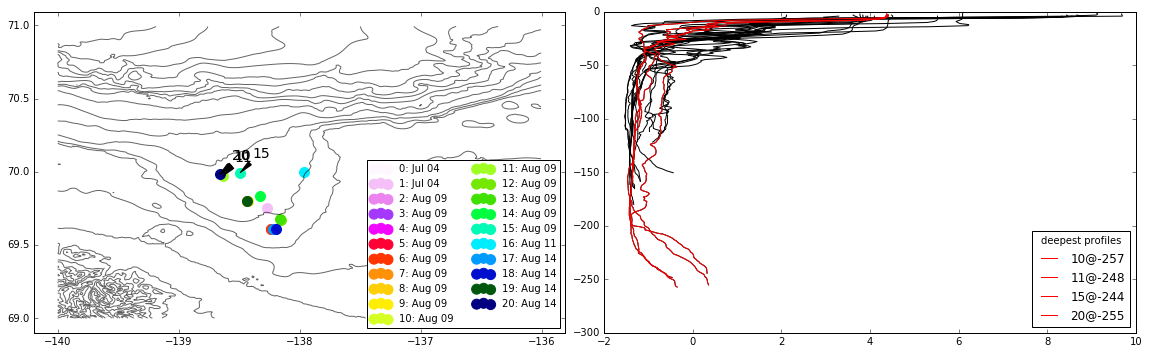

In [48]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,5)); plt.tight_layout()
fig, ax1 = functions_plot.plot_region(fig, ax1, xn, yn, zn)
c = cm.gist_ncar_r(np.linspace(0, 1, len(day)))
for i in range(len(longitude)):
    ax1.scatter(longitude[i], latitude[i], color=c[i], label = str(i) + ': ' + dates[i], s=100)
ax1.legend(ncol = 2, fontsize=10, loc=4)

ax2.plot(con_temp, depth, 'k')
for j in zip([10, 11, 15, 20]): # I found the profiles deeper than -240
    ax1.annotate(str(j[0]), xy=(longitude[j], latitude[j]), 
                 xytext=(longitude[j]+0.1, latitude[j]+0.1), 
                 arrowprops=dict(facecolor='black', headwidth=4), fontsize=14)
    ax2.plot(con_temp[:,j], depth[:,j], 'r', label=str(j[0])+'@'+str(int(np.nanmin(depth[:,j]))))
ax2.legend(title='deepest profiles', loc=4)
plt.show()

I like the 10th profile for now since it's the deepest one. Remove nans. Any extrapolation will use the last value in the profile (bounds error and fill_value).

In [129]:
profile = 10
prof_d = depth[:, profile]
prof_t = con_temp[:, profile]
ind_end = np.where(prof_d == np.nanmin(prof_d))[0][0]
prof_ctemp = prof_t[:ind_end+1]
prof_depth = prof_d[:ind_end+1]

In [137]:
# salishsea has default - linear. Should I make cubic?
interp_ctemp = interpolate.interp1d(prof_depth, prof_ctemp, bounds_error=False, fill_value=prof_ctemp[-1])

Grab depths from bathymetry - using idealized bathy first.

In [162]:
#grid_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/initial_sets/grid/grid_01.nc')
bath_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/initial_sets/idealized/ideal_bathy_01.nc')
bathy = bath_file['Bathymetry'][:]
prof_bathy = bathy[:,58]

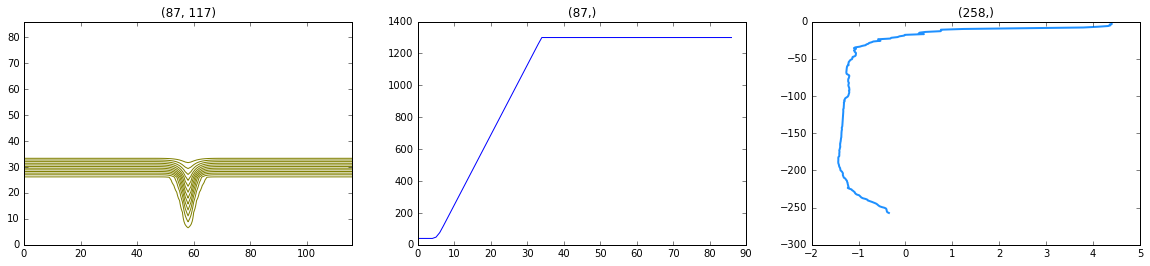

In [164]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,4))
ax1.contour(bathy, 15, linestyles='solid', colors = 'Olive', lw=2); ax1.set_title(str(bathy.shape))
ax2.plot(prof_bathy); ax2.set_title(str(prof_bathy.shape))
ax3.plot(prof_ctemp, prof_depth, c = 'DodgerBlue',lw=2); ax3.set_title(str(prof_ctemp.shape))

In [156]:
votemper = np.zeros((1, len(bathy)-1, bathy.shape[1], bathy.shape[0]))
print(votemper.shape)

votemper[0,0,:,:] = prof_ctemp[0]

(1, 86, 117, 87)


In [165]:
for id in range(1,len(prof_bathy)):
    votemper[0,id,:,:] = interp_ctemp(prof_bathy[id])

IndexError: index 86 is out of bounds for axis 1 with size 86

In [ ]:
bathy